<a href="https://colab.research.google.com/github/mleiwe/HostileBGP/blob/main/GCP_MLattempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Guide

In [46]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=420e5ec62cb3a2fe959e1593f11abdd9c45d87ca0ea3c2e82dc578c04534b86e
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [47]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as LGB

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

import sklearn as sk
import xgboost as xgbm


In [48]:
print(f"Pandas version = {pd.__version__}")
print(f"Seaborn version = {sns.__version__}")
print(f"Numpy version = {np.__version__}")
print(f"SciKit Learn version = {sk.__version__}")
print(f"XGBoost version = {xgbm.__version__}")
print(f"LightGBM version = {LGB.__version__}")


Pandas version = 1.5.3
Seaborn version = 0.13.1
Numpy version = 1.23.5
SciKit Learn version = 1.2.2
XGBoost version = 2.0.3
LightGBM version = 4.1.0


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# Get the file as a pkl
!wget https://raw.githubusercontent.com/ctestart/BGP-SerialHijackers/master/groundtruth_dataset.csv

--2024-01-26 05:51:30--  https://raw.githubusercontent.com/ctestart/BGP-SerialHijackers/master/groundtruth_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160092 (156K) [text/plain]
Saving to: ‘groundtruth_dataset.csv.1’

groundtruth_dataset 100%[===================>] 156.34K  --.-KB/s    in 0.004s  

2024-01-26 05:51:30 (38.0 MB/s) - ‘groundtruth_dataset.csv.1’ saved [160092/160092]



In [51]:
df = pd.read_csv('groundtruth_dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,0_drops,10p_adTime,10p_pfx_medianVis,1p_MOASlen,6months_percent,85p_beta_daybins,85p_beta_monthbins,85p_beta_weekbins,90p_adTime,90p_pfx_medianVis,...,rir_count,rir_gini_add,rir_gini_pfx,std_MOASlen,top_rir_add,top_rir_pfx,unassigned%_add,unassigned%_pfx,var_MOASlen,class
0,0,242.621528,0.061404,0.000012,0.962963,0.083333,0.250000,0.100000,1825.059028,0.847491,...,1,0.800000,0.800000,42.007607,1.000000,1.000000,0.000000,0.000000,1764.639046,0
1,0,1825.364583,0.835135,0.000012,1.000000,0.047619,0.142857,0.047619,1825.406250,0.854883,...,1,0.800000,0.800000,42.007607,1.000000,1.000000,0.000000,0.000000,1764.639046,0
2,8,0.413194,0.056797,0.000012,0.000000,0.285714,3.727273,1.333333,11.923611,0.075905,...,4,0.650980,0.650980,36.154282,0.764706,0.764706,0.150000,0.150000,1307.132140,1
3,0,7.121528,0.021666,0.000012,0.625442,0.052632,0.143823,0.052632,1043.545139,0.876315,...,5,0.791601,0.773108,61.594263,0.982875,0.958900,0.986129,0.001359,3793.853192,0
4,0,1.184028,0.393271,0.000012,0.728933,0.019802,0.431953,0.108108,1822.576389,0.897931,...,2,0.799703,0.799437,51.365640,0.999257,0.998594,0.045415,0.001404,2638.428960,0


# Basic EDA
Here I'm just checking for...
* The type of data
* Any missing values
* Any correlations/trends that can simplify the performance

In [52]:
df.describe()

,0_drops,10p_adTime,10p_pfx_medianVis,1p_MOASlen,6months_percent,85p_beta_daybins,85p_beta_monthbins,85p_beta_weekbins,90p_adTime,90p_pfx_medianVis,...,rir_count,rir_gini_add,rir_gini_pfx,std_MOASlen,top_rir_add,top_rir_pfx,unassigned%_add,unassigned%_pfx,var_MOASlen,class
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,5.404167,79.213701,0.293372,0.000010,0.488000,0.199661,1.079463,0.352927,1173.514482,0.761709,...,1.954167,0.773848,0.767037,40.705966,0.948722,0.937805,0.054170,0.013386,2001.727683,0.095833
std,28.591466,249.458998,0.322998,0.000004,0.315367,0.300630,1.954199,0.543991,684.345281,0.237964,...,1.300942,0.063957,0.071686,18.606302,0.115118,0.129891,0.153996,0.042227,1110.301883,0.294978
min,0.000000,0.000000,0.013072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020761,...,1.000000,0.339691,0.420227,0.000000,0.439155,0.399303,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.013889,0.028372,0.000012,0.197475,0.022727,0.147191,0.052013,633.955729,0.820324,...,1.000000,0.789109,0.783169,42.007607,0.972973,0.958759,0.000000,0.000000,1764.639046,0.000000
50%,0.000000,0.230903,0.086181,0.000012,0.500000,0.085145,0.418597,0.158312,1388.166667,0.852805,...,1.000000,0.800000,0.800000,42.007607,1.000000,1.000000,0.000000,0.000000,1764.639046,0.000000
75%,2.000000,21.154514,0.643726,0.000012,0.771051,0.200000,1.000000,0.400000,1824.536458,0.873819,...,2.000000,0.800000,0.800000,51.365640,1.000000,1.000000,0.026794,0.005839,2638.428960,0.000000
max,407.000000,1825.364583,0.900369,0.000012,1.000000,2.000000,12.181818,4.454545,1825.472222,0.930228,...,5.000000,0.800000,0.800000,61.594263,1.000000,1.000000,0.986129,0.363636,3793.853192,1.000000


In [53]:
#check for missing values
df.isna().sum()

0_drops                     0
10p_adTime                  0
10p_pfx_medianVis           0
1p_MOASlen                  0
6months_percent             0
85p_beta_daybins            0
85p_beta_monthbins          0
85p_beta_weekbins           0
90p_adTime                  0
90p_pfx_medianVis           0
95p_alpha_daybins           0
95p_alpha_monthbins         0
95p_alpha_weekbins          0
99p_MOASlen                 0
ASN                         0
MOAS_add%                   0
MOAS_pfx_%                  0
Uptime                      0
bogons%_add                 0
bogons%_pfx                 0
highMaxVis_percent          0
highMedVis_percent          0
lowMaxVis_percent           0
lowMedVis_percent           0
median/unique_pfx           0
median_adTime               0
median_adTime_highMaxVis    0
median_adTime_highMedVis    0
median_adTime_lowMaxVis     0
median_adTime_lowMedVis     0
median_pfx_medianVis        0
q1_adTime                   0
q1_adTime_highMaxVis        0
q1_adTime_

<Axes: >

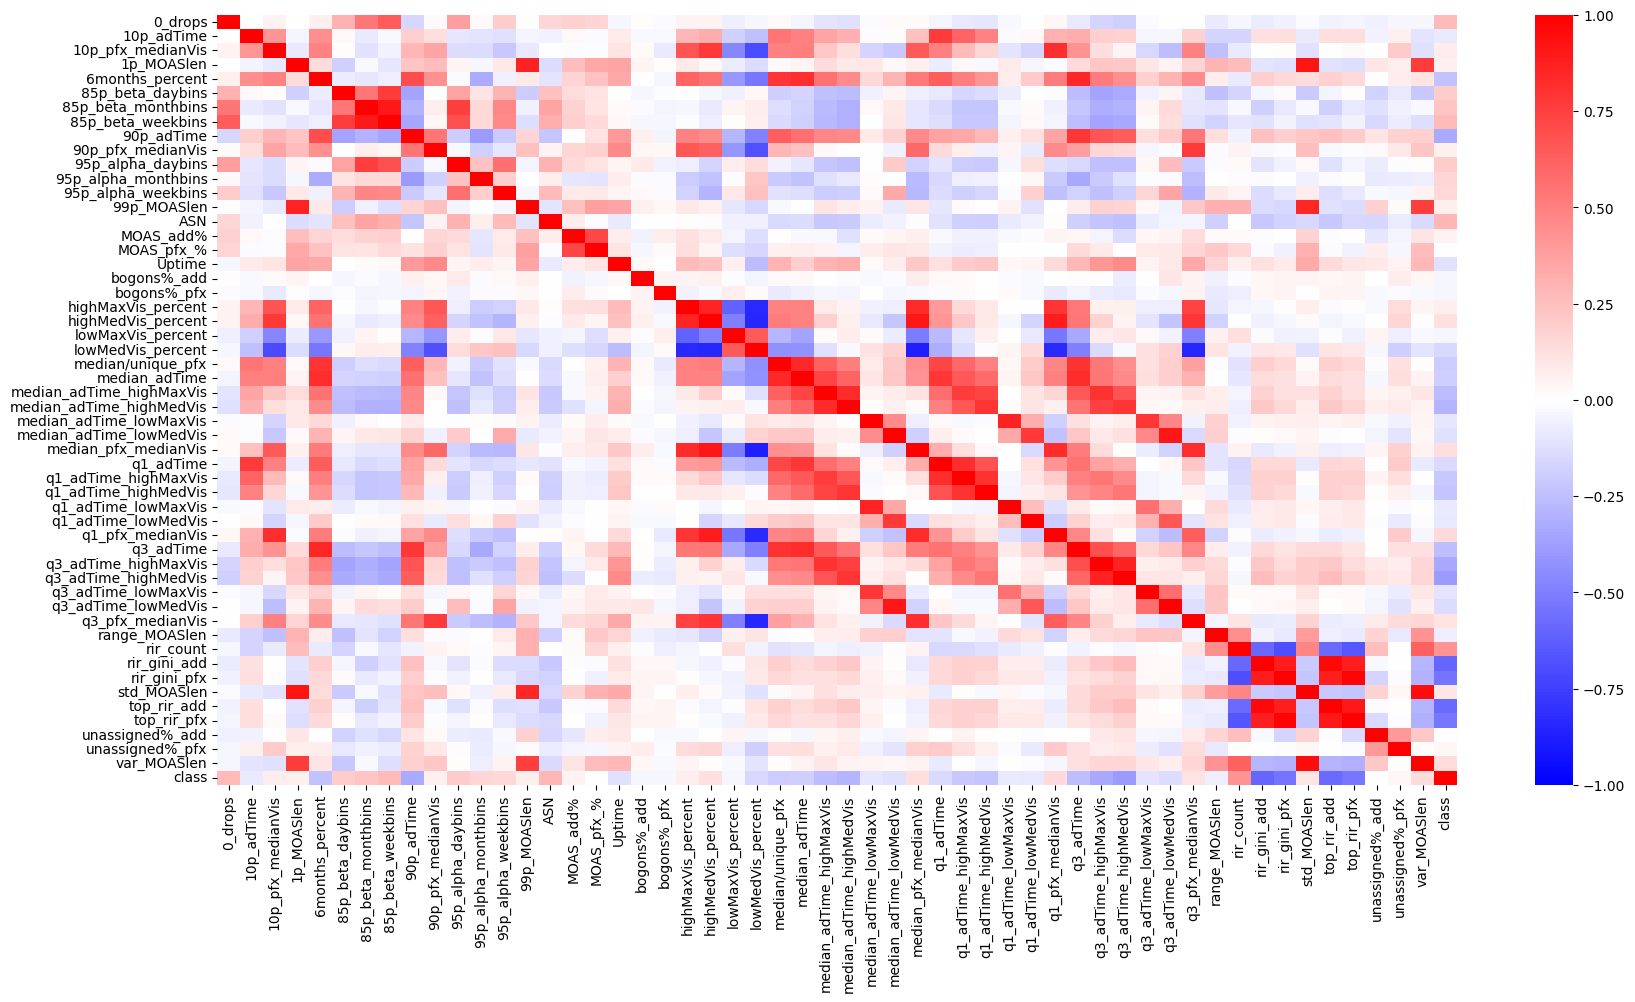

In [54]:
#Perform pearson's correlation
CrossCorrMat = df.corr()
fig = plt.figure(figsize=(20,10))
sns.heatmap(data=CrossCorrMat, cmap='bwr', vmin=-1, center=0, vmax=1, xticklabels=True, yticklabels=True)

Red = positively correlated, and Blue = negatively correlated.

There appears to be a lot of correlation between values, both negatively and positively. This suggests that there is likely a lot of redundant data within the set. In the future to speed up performance we possibly don't need so many variables (n=52, at the moment).

To get actual numbers. I'll plot it  again with the values shown.

<Axes: >

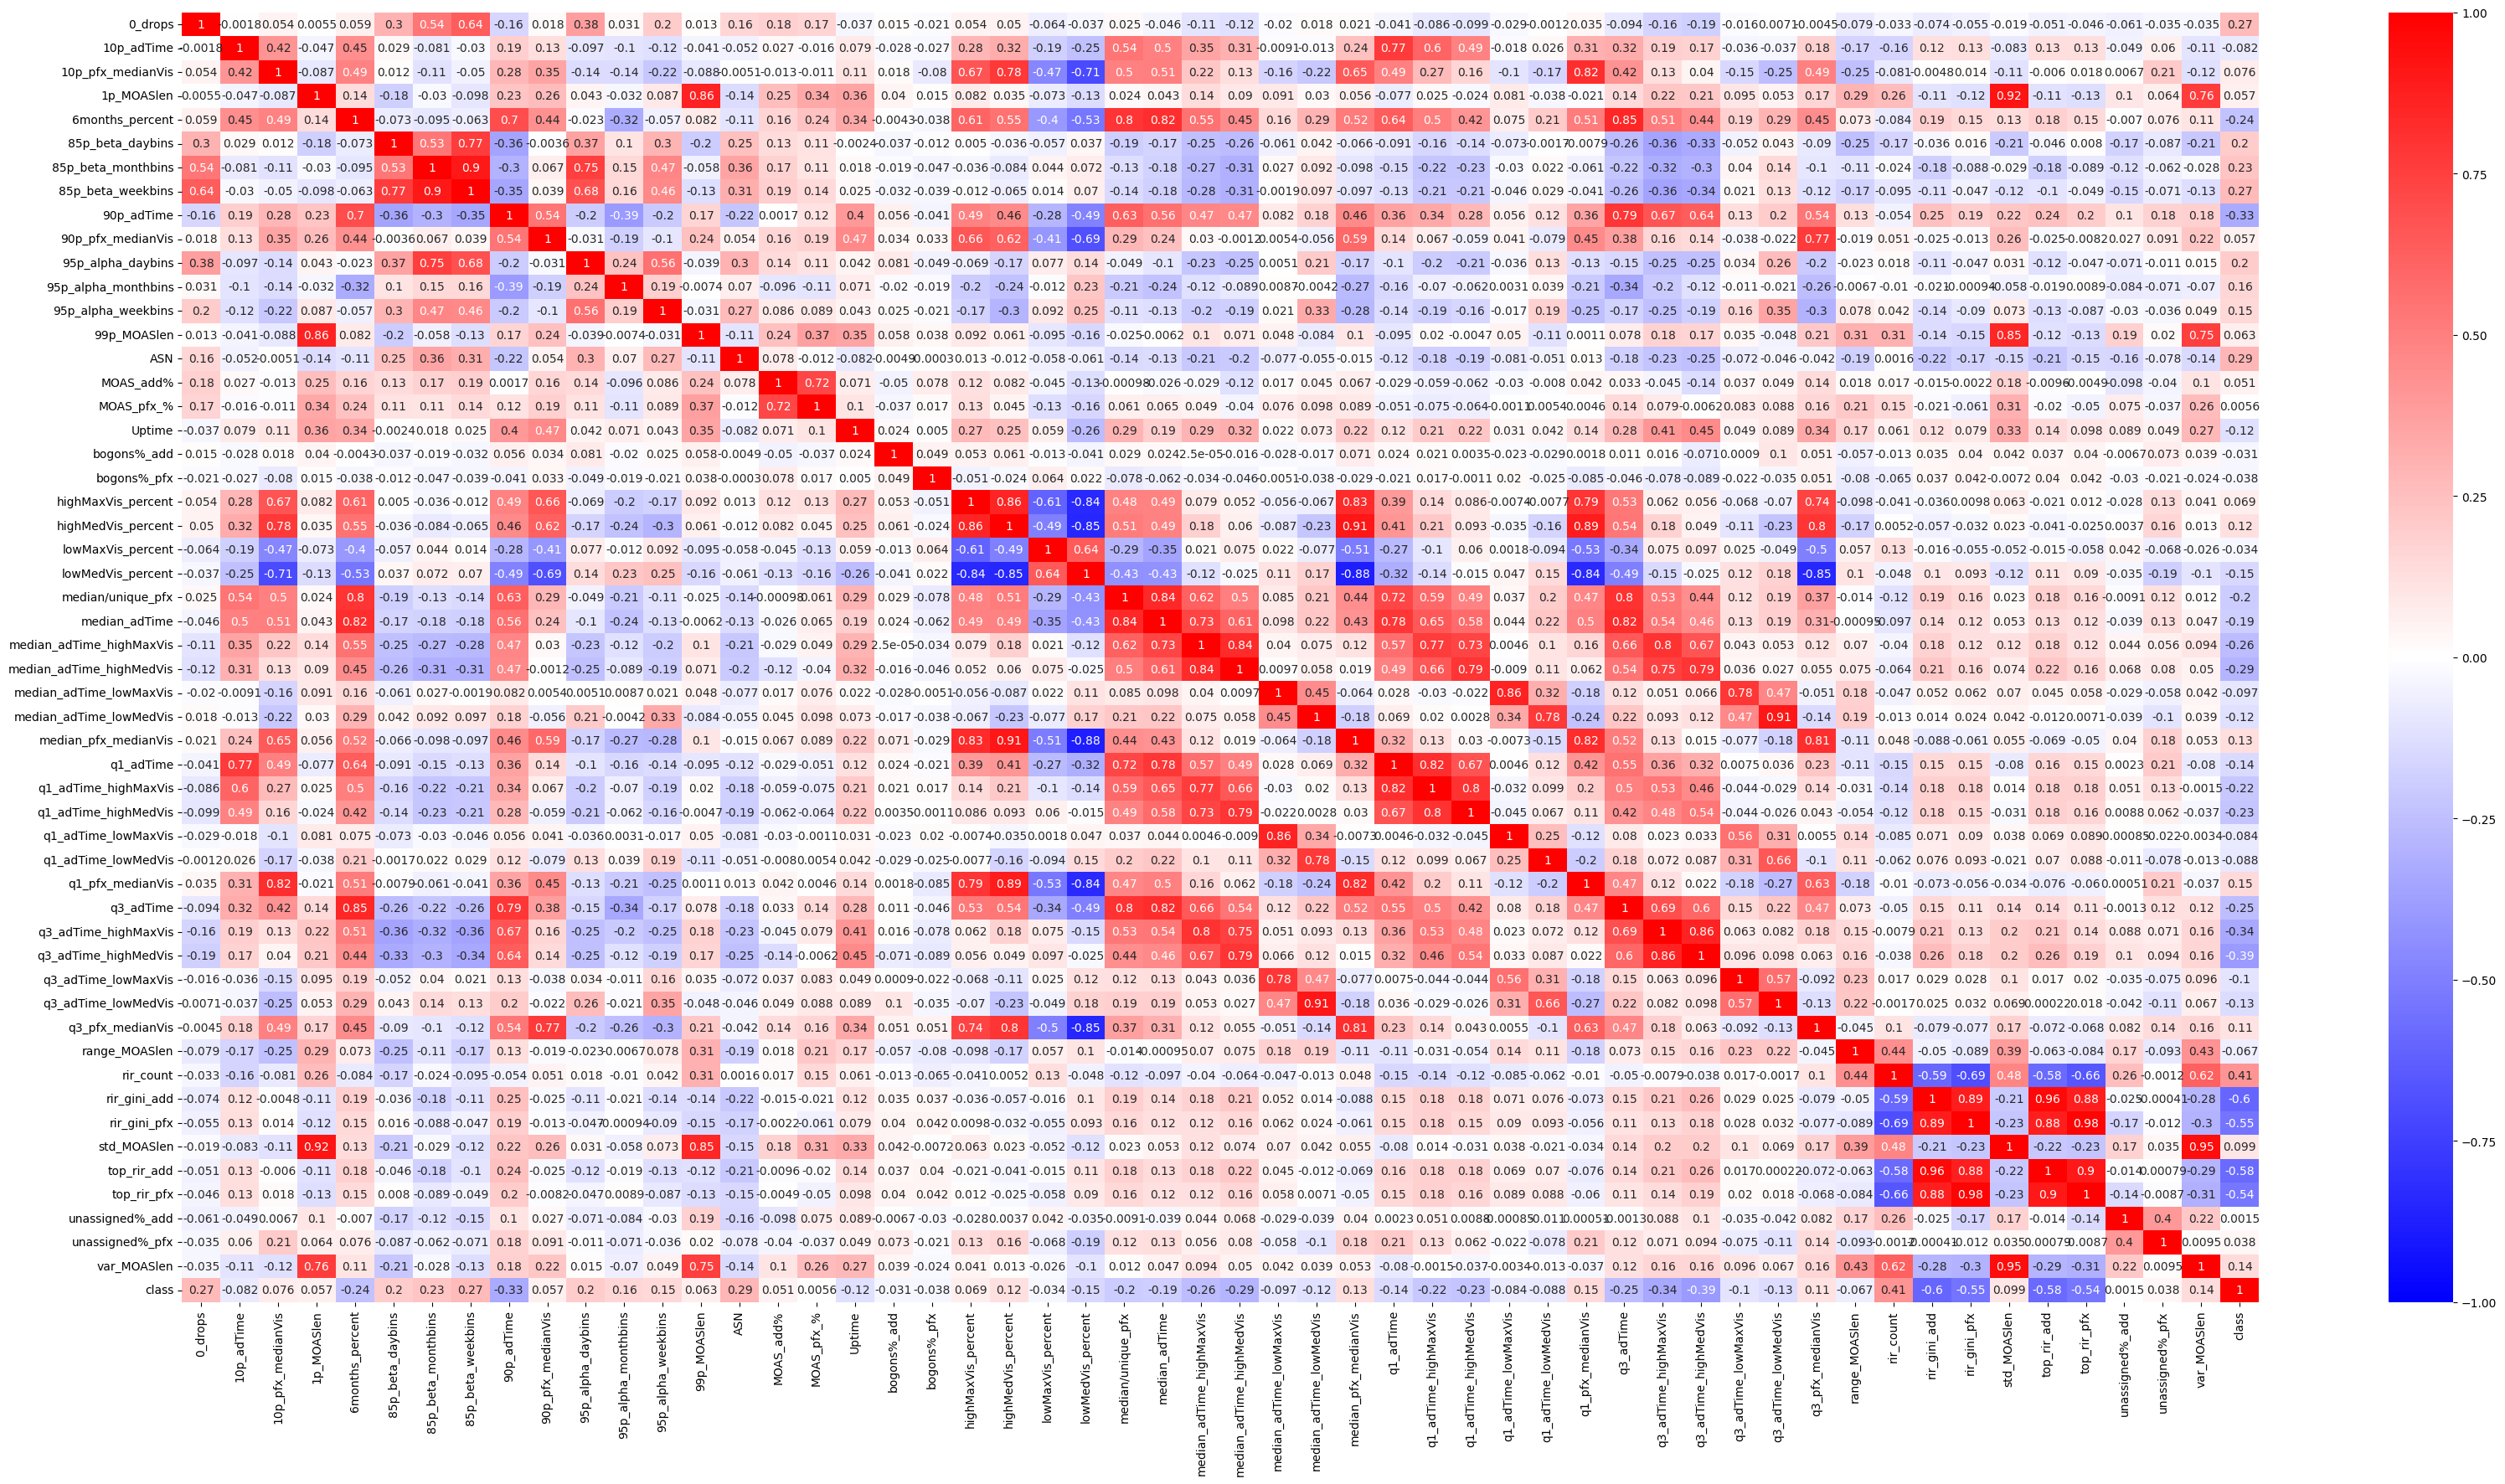

In [55]:
fig = plt.figure(figsize=(40,20))
sns.heatmap(data=CrossCorrMat, cmap='bwr', vmin=-1, center=0, vmax=1,  annot=True, xticklabels=True, yticklabels=True)

If you look at the bottom row. It lists the correlations to class. Looking for high positive and negative numbers will give us an indication that the values are correlated. My cut off will be +/- 0.33, and the following values are important.

In [56]:
PosThresh = 0.33
NegThresh = -0.33
Cols = CrossCorrMat.columns

pos_cor_idx = CrossCorrMat.iloc[-1] >= PosThresh
neg_cor_idx = CrossCorrMat.iloc[-1] <= NegThresh

pos_cor = Cols[pos_cor_idx]
pc = []
for i in pos_cor:
  pc.append(i)
neg_cor = Cols[neg_cor_idx]
nc = []
for i in neg_cor:
  nc.append(i)
print(f"Positively correlated variables to class are: {pc}")
print(f"Negatively correlated variables to class are: {nc}")


Positively correlated variables to class are: ['rir_count', 'class']
Negatively correlated variables to class are: ['90p_adTime', 'q3_adTime_highMaxVis', 'q3_adTime_highMedVis', 'rir_gini_add', 'rir_gini_pfx', 'top_rir_add', 'top_rir_pfx']


So 8 very strong correlative values might even be enough in most cases. Or fewer may be useful (e.g. `q3_adTime_highMaxVis` and `q3_adTime_highMedVis` are very highly correlated).

However for now lets use everything, to make it as consistent as possible.

# Preparing data for training
`class` is the target variable `y`.
`ASN` is just the name of the ASN so should not be used for training. This will be stored as `id`.
The remaining variables will be used to train the model and will be in the data frame `X`

In [70]:
#Split data
y = df['class'].astype('category')
y = y.astype('category')
id = df['ASN']
X = df.drop(['ASN','class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=1) #stratifies according to the class in y

<Axes: xlabel='class', ylabel='count'>

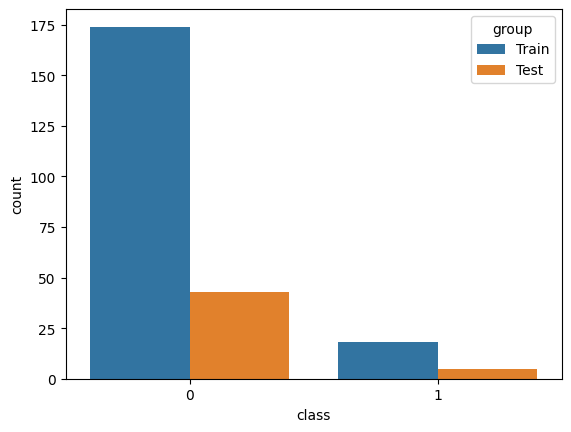

In [71]:
class_vals = pd.concat([y_train,y_test])
group_vals = []
for i in range(len(y_train)):
  group_vals.append('Train')

for i in range(len(y_test)):
  group_vals.append('Test')

temp = {
    'class' : class_vals,
    'group': group_vals
}
sns.countplot(data=temp, x='class', hue='group')

# Model Evaluation

## Util

In [72]:
#GridSearchCV uses a stratified k-fold for training so I can go ahead and use it. I've created a small function to process each model
def evaluate_model(model,param_grid,X,y,X_test,y_test,eval_score='f1'):
  '''
  Function that performs a grid search on the model chosen. Aim is to return the best parameters
  Inputs
  model - The instatiated model. e.g. etc for etc = ExtraTreesClassifier()
  param_grid - The parameter grid to test
  X - The X_train data
  y - The y_train data
  eval_score - Strategy to evaluate the performance of the cross-validated model on the test set. Variable for GridSearchCV, default is the F1 score

  Outputs
  Best_Parameters - The model parameters that produce the best results
  Time_Taken - The time for a single process
  Test_Score - The score on the test set
  '''
  Grid_Search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    scoring = eval_score,
    verbose = 1
    )
  Grid_Search.fit(X,y)
  y_pred = Grid_Search.predict(X_test)
  Best_Parameters = Grid_Search.best_estimator_.get_params()
  Time_Taken = Grid_Search.refit_time_
  Test_Score = f1_score(y_test, y_pred, average='weighted')
  print (f'F1 score on test set: {np.round(Test_Score,4)}')
  print (classification_report(y_test, y_pred))

  CM = confusion_matrix(y_test, y_pred)
  cm_disp = ConfusionMatrixDisplay(CM)
  cm_disp.plot()

  #Precision-Recall Curve Stats
  y_pred = Grid_Search.predict_proba(X_test)[:,1]
  #print(y_pred[:,1])
  precision, recall, thresh = precision_recall_curve(y_test,y_pred)

  return Best_Parameters, Time_Taken, Test_Score, precision, recall, thresh

In [73]:
Model_dict = {
    'Model': [],
    'F1_Score': [],
    'Precision': [],
    'Recall': [],
    'Thresholds': [],
    'Parameters': [],
    'Time': []
}

## Models

### Extra Trees Classifier

Fitting 5 folds for each of 128 candidates, totalling 640 fits
F1 score on test set: 0.9536
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.60      0.75         5

    accuracy                           0.96        48
   macro avg       0.98      0.80      0.86        48
weighted avg       0.96      0.96      0.95        48



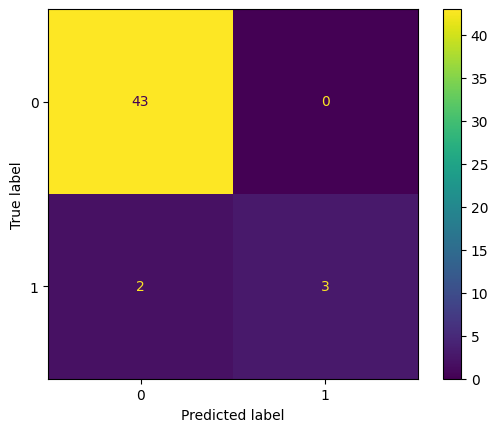

In [74]:
etc = ExtraTreesClassifier()
#ExtraTrees -used in paper (n_estimators=500, bootstrap=True, oob_score=True)
Param_Grid = {
    'criterion': ['gini', 'log_loss'],
    'n_estimators': [300, 400, 500, 550],
    'max_depth': [None, 5, 10, 20],
    'max_leaf_nodes': [None, 2, 5, 10],
    'bootstrap': [True],
    'oob_score': [True],
    'random_state': [42]
}


param, time, score, precision, recall, thresh = evaluate_model(etc,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('Extra Trees Classifier')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

### Random Forest Classifier

Fitting 5 folds for each of 27 candidates, totalling 135 fits
F1 score on test set: 0.9781
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.80      0.89         5

    accuracy                           0.98        48
   macro avg       0.99      0.90      0.94        48
weighted avg       0.98      0.98      0.98        48



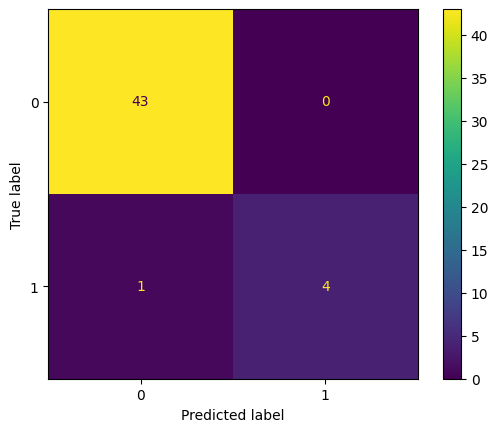

In [75]:
rfc = RandomForestClassifier()

Param_Grid = {'n_estimators': [40, 50, 60],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [30, 40, 50],
              'min_samples_leaf': [1],
              'max_features' : [None]
             }

param, time, score, precision, recall, thresh = evaluate_model(rfc,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('Random Forest Classifier')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

### XGBoost

Fitting 5 folds for each of 81 candidates, totalling 405 fits
F1 score on test set: 0.9536
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.60      0.75         5

    accuracy                           0.96        48
   macro avg       0.98      0.80      0.86        48
weighted avg       0.96      0.96      0.95        48



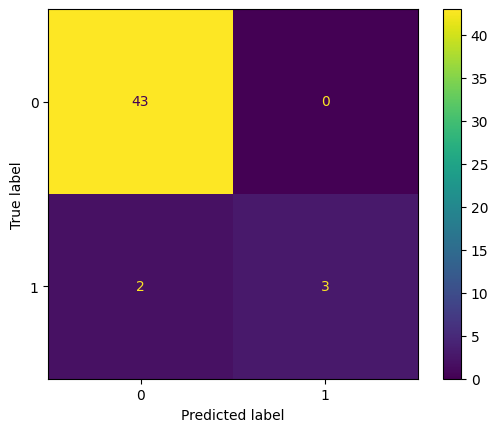

In [76]:
Param_Grid = {'max_depth': [2, 5, 7],
              'learning_rate': [0.02, 0.04, 0.05],
              'n_estimators': [400, 500, 600],
              'gamma' : [0],
              'min_child_weight': [0.01, 0.1, 0.2]
             }
xgb = XGBClassifier()
param, time, score, precision, recall, thresh = evaluate_model(xgb,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('XGBoost')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

### LightGBM

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 18, number of negative: 174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2215
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093750 -> initscore=-2.268684
[LightGBM] [Info] Start training from score -2.268684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

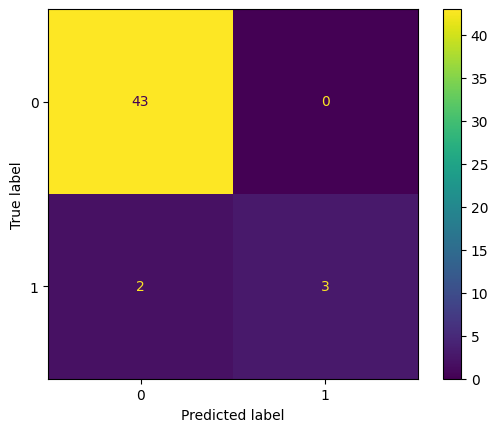

In [77]:

Param_Grid = {'boosting_type': ['gbdt'],
              'num_leaves': [10, 20, 31, 40, 50],
              'learning_rate': [0.025, 0.05],
              'n_estimators': [100, 400, 500, 600],
              'min_child_samples': [1, 5, 10]
             }

lgb = LGB.LGBMClassifier(objective='binary', random_state=42, max_depth=-1)
param, time, score, precision, recall, thresh = evaluate_model(lgb,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('Light GBM')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

### Support Vector Machine

Fitting 5 folds for each of 5 candidates, totalling 25 fits
F1 score on test set: 0.8466
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        43
           1       0.00      0.00      0.00         5

    accuracy                           0.90        48
   macro avg       0.45      0.50      0.47        48
weighted avg       0.80      0.90      0.85        48



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


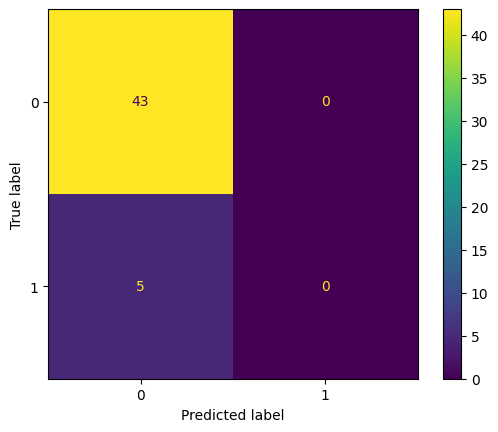

In [78]:
Param_Grid = {'C': [0.5, 0.75, 1, 1.25, 2],
              'kernel': ['rbf'],
              'gamma': ['scale']
             }

svc = SVC(random_state=42, probability=True)
param, time, score, precision, recall, thresh = evaluate_model(svc,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('Support Vector Machine')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

### Logistic Regression

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

F1 score on test set: 0.9781
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.80      0.89         5

    accuracy                           0.98        48
   macro avg       0.99      0.90      0.94        48
weighted avg       0.98      0.98      0.98        48



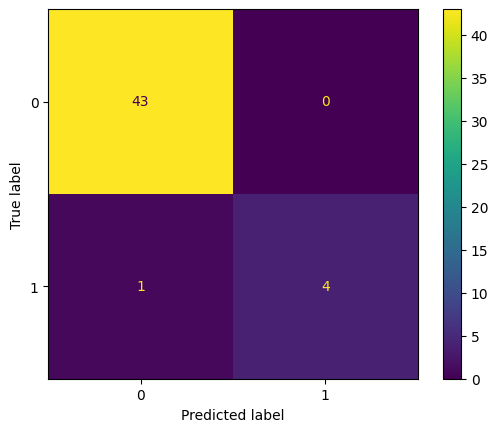

In [79]:
Param_Grid = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [0.0001, 0.001, 0.005],
              'solver': ['lbfgs', 'liblinear'],
              'max_iter': [25, 50, 100, 150]
             }

lrc = LogisticRegression(random_state=42, multi_class='ovr')
param, time, score, precision, recall, thresh = evaluate_model(lrc,Param_Grid,X_train,y_train, X_test, y_test,'f1')

Model_dict['Model'].append('Logisitc Regression Classifier')
Model_dict['F1_Score'].append(score)
Model_dict['Parameters'].append(param)
Model_dict['Time'].append(time)
Model_dict['Precision'].append(precision)
Model_dict['Recall'].append(recall)
Model_dict['Thresholds'].append(thresh)

## Evaluation

### F1 Scores and Processing Time

Text(0.5, 1.0, 'Processing time of models')

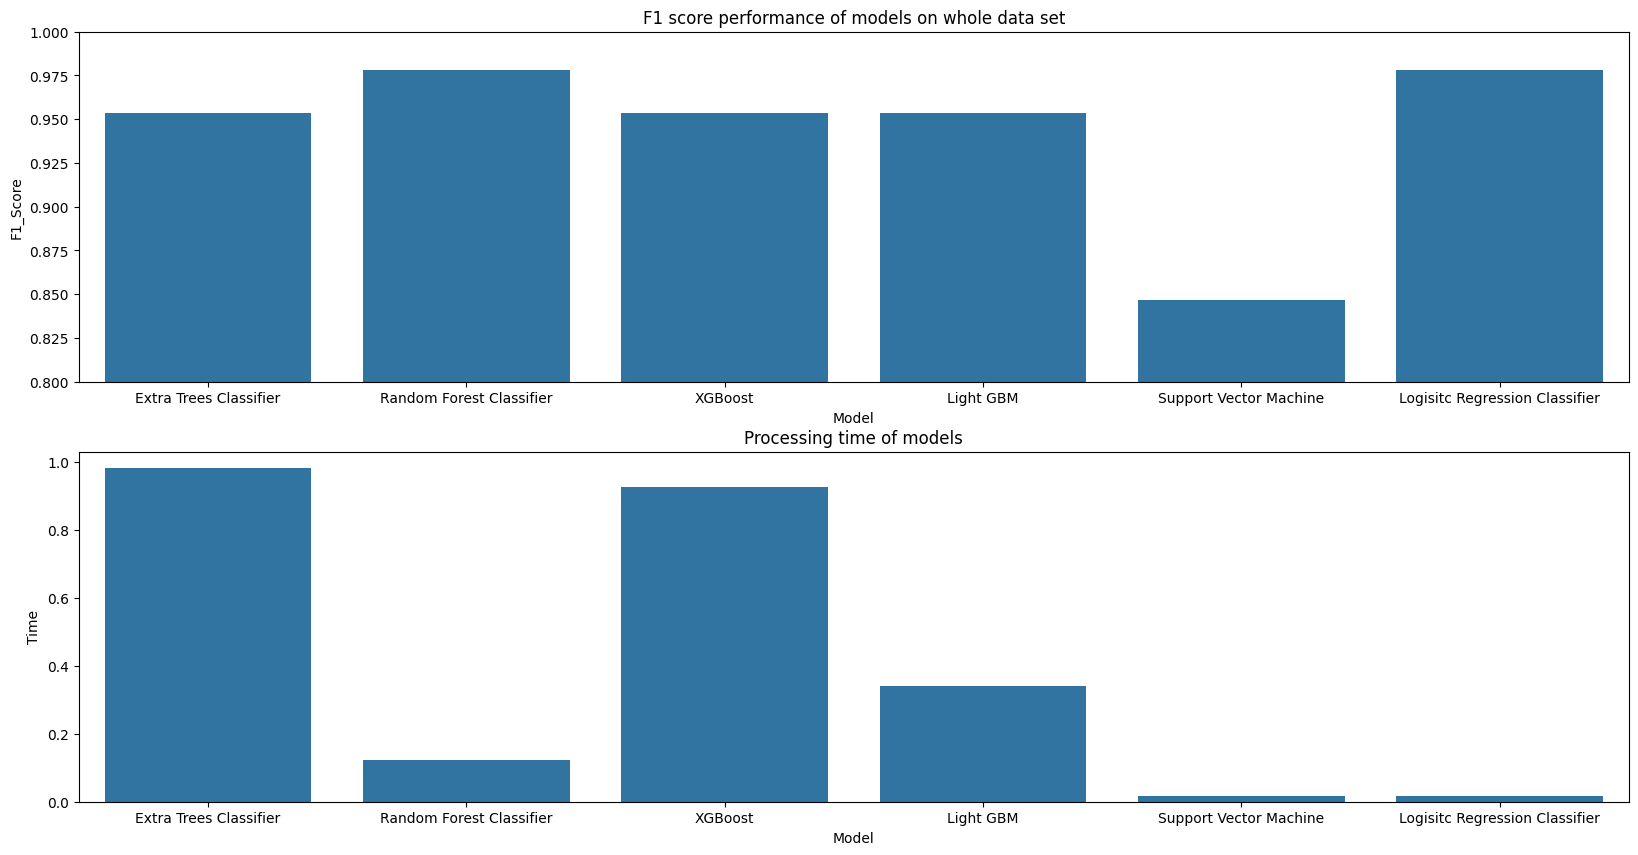

In [80]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
sns.barplot(data=Model_dict, x='Model', y='F1_Score', ax=ax[0])
sns.barplot(data=Model_dict, x='Model', y='Time', ax=ax[1])
ax[0].set_title("F1 score performance of models on whole data set")
ax[0].set_ylim(0.8,1)
ax[1].set_title("Processing time of models")

### Precision-Recall Curves

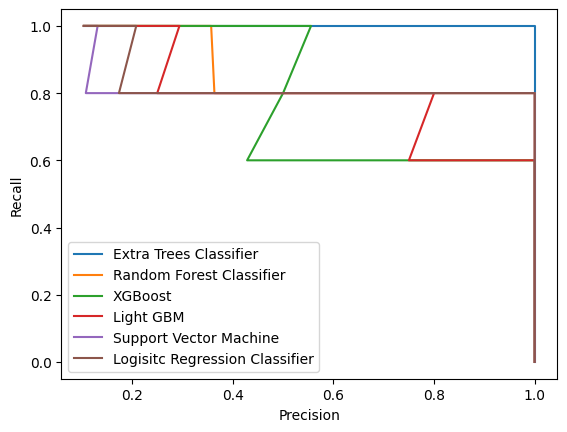

In [81]:
for i in range(len(Model_dict['Model'])):
  name = Model_dict['Model'][i]
  p = Model_dict['Precision'][i]
  r = Model_dict['Recall'][i]
  plt.plot(p,r, label=name)

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()


So extra trees might be better, if we change the prediction threshold. But with the limited data available it's not really fair to comment. 5 hostiles isn't enough to be definitative. 

Regarding processing time the ExtraTrees Classifier is the slowest, I recommend using LightGBM, Random Forrest classifier, or Logisitic Regression instead.